In [2]:
# Loading all packages + ignoring warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import requests
from datetime import datetime
import json
import matplotlib
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits

In [9]:


# df2.to_csv("googledata29082018.csv", index=False)
df2 = pd.read_csv("googledata29082018.csv")
df2.head(3)


,Year,Month,Average_GI_job,Average_GI_dagpenge,Average_GI_kontanthjælp,Average_GI_akasse,Average_GI_jobnet
0,2007,1,93,47,22,37,34
1,2007,2,84,35,22,28,33
2,2007,3,74,42,24,35,33


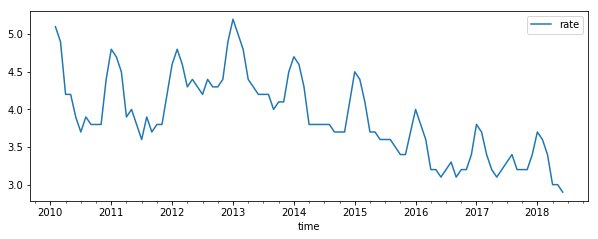

In [10]:
###-------------User input start----------------###
# Number of lags for explanatory variables
n_lags = 1
# Should be set to 1 for seasonally adjusted unemployment data and 0 otherwise
season_adjustment = 0
# Specify type of unemployment - 'ILO-unemp', 'Net unemp' or 'Gross unemp'
unemp_type = 'Net unemp'
# Number of months from 2007-01 to cut
cut_n_months = 36
###--------------User input end-----------------###

# Importing unemployment data from statbank.dk
AKUurl = 'https://api.statbank.dk/v1/data/AKU125/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&S%C3%86SON=11&S%C3%86SON=10&BESKSTATUS=LPCT&TID=*'
AKUcsv = pd.read_csv(AKUurl, sep = ";")
unemp_url = 'https://api.statbank.dk/v1/data/AUS07/CSV?lang=en&valuePresentation=Value&timeOrder=Descending&delimiter=Semicolon&allowVariablesInHead=true&YD=TOT&YD=NET&TID=*&SAESONFAK=9&SAESONFAK=22'
raw_unemp = pd.read_csv(unemp_url, sep = ";")

# Reshaping and constructing dummies for filtering
AKUcsv['season_adj'] = np.where(AKUcsv['SÆSON'] == 'Non-seasonally adjusted', 0, 1)
AKUcsv.columns = ['todrop', 'type', 'time', 'rate', 'season_adj']
AKUcsv['type'] = AKUcsv['type'].str.replace(r'rate', r'')
AKU = AKUcsv.drop('todrop', axis=1)
raw_unemp['season_adj'] = np.where(raw_unemp['SAESONFAK'] == 'Seasonally adjusted figures in percent of the labour force', 1, 0)
raw_unemp.columns = ['type', 'time', 'SAESONFAK', 'rate', 'season_adj']
unemp = raw_unemp.drop('SAESONFAK', axis=1)

# Merge data 
df_all = pd.concat([AKU, unemp], ignore_index=True)
#print(df_all.head())

# Convert variable time to date format and sort by date
df_all['time'] = df_all['time'].str.replace(r'\D', r' ')
df_all['time'] = pd.to_datetime(df_all['time'], format = "%Y %m" )
df_all = df_all.sort_values('time')

# Shortening of type names
df_all['type'] = df_all['type'].str.replace(r'unemployment', r'unemp')
df_all['type'] = df_all['type'].str.strip()
#print(df_all)

# Creating df that contains data for relevant type of unemployment.
unemp_rates = df_all[(df_all['season_adj']==season_adjustment) & (df_all['type']==unemp_type)].drop(columns='season_adj')
unemp_rates = unemp_rates.reset_index(drop=True)

# Copying unemployment rates for creating first difference variable later
unemp_rates_first_diff = unemp_rates.copy()

# Create varaible lagged unemplyment rate
df2['unemp_lag1'] = unemp_rates['rate'].shift(n_lags)

# Create variables for lagged average GIs
df3 = df2.copy()
df3['GI_job_lag1'] = df3['Average_GI_job'].shift(n_lags)
df3['GI_dagpenge_lag1'] = df3['Average_GI_dagpenge'].shift(n_lags)
df3['GI_kontanthjælp_lag1'] = df3['Average_GI_kontanthjælp'].shift(n_lags)
df3['GI_a-kasse_lag1'] = df3['Average_GI_akasse'].shift(n_lags)
df3['GI_jobnet_lag1'] = df3['Average_GI_jobnet'].shift(n_lags)

# Removing first observation in both dataframes, sinces df3 now contains NA i first row
# Additionally ensuring that d4 and unemp_rates have the same number of columns
df4 = df3[(n_lags+cut_n_months):len(unemp_rates)]
unemp_rates = unemp_rates[(n_lags+cut_n_months):]


# Construction X and y
X = np.array(df4[['GI_job_lag1',
                  'GI_dagpenge_lag1',
                  'GI_kontanthjælp_lag1', 
                  'GI_a-kasse_lag1',
                  'GI_jobnet_lag1',
                  'unemp_lag1'
                 ]]) # creating ndarray of X values (2 variables)
X_ar = np.array(df4[['unemp_lag1']]) # creating ndarray of X values (2 variables)
y = np.array(unemp_rates[['rate']])


# Security check to ensure that length of variable lists match.
if (len(X)-len(y)!=0):
    print('-------------------------------------------------------------------')
    print('----WARNING: Number of observations in X and y does not match!!----')
    print('---------------Length of y: ' + str(len(y)) + '. Length of X: ' + str(len(X)) + '------------------')
    print('-------------------------------------------------------------------')
unemp_rates.plot(x='time', y='rate', figsize=(10,3.5))

# Constructing first diff y
unemp_rates_first_diff['unemp_rate_fd'] = unemp_rates_first_diff['rate']-unemp_rates_first_diff['rate'].shift(1)
unemp_rates_first_diff = unemp_rates_first_diff[1+cut_n_months:]
y_fd = np.array(unemp_rates_first_diff[['unemp_rate_fd']])


In [11]:
# Split into continous time series
###----------------User input start------------------###
train_share = 0.5
validation_share = 0.3
test_share = 0.2
# Specify X - should be either 'X' og 'X_ar' (autoregressive).
X_type = X
# Specify y - should be either y or y_fd (first diff)
y = y_fd
###-----------------User input end-------------------###

dev_share = train_share + validation_share

# Constructing samples split
X_dev_ts = X_type[:int(len(X_type)*dev_share)]
X_train_ts = X_type[:int(len(X_type)*train_share)]
X_val_ts = X_type[int(len(X_type)*train_share):int(len(X_type)*dev_share)]
X_test_ts = X_type[int(len(X_type)*dev_share):] 

if (len(X_train_ts)+len(X_val_ts)+len(X_test_ts))!= len(X_type):
    print('--------WARNING LENGTHS DO NOT MATCH!!-----------')
else:
    print('len(X_dev_ts): ' + str(len(X_dev_ts)))
    print('len(X_train_ts): ' + str(len(X_train_ts)))
    print('len(X_val_ts): ' + str(len(X_val_ts)))
    print('len(X_test_ts): ' + str(len(X_test_ts)))

y_dev_ts = y[:int(len(y)*dev_share)]    
y_train_ts = y[:int(len(y)*train_share)]
y_val_ts = y[int(len(y)*train_share):int(len(y)*(dev_share))]
y_test_ts = y[int(len(y)*dev_share):] 

if (len(y_train_ts)+len(y_val_ts)+len(y_test_ts))!= len(y):
    print('--------WARNING LENGTHS DO NOT MATCH!!-----------')
else:
    print('len(y_dev_ts): ' + str(len(y_dev_ts)))
    print('len(y_train_ts): ' + str(len(y_train_ts)))
    print('len(y_val_ts): ' + str(len(y_val_ts)))
    print('len(y_test_ts): ' + str(len(y_test_ts)))

len(X_dev_ts): 80
len(X_train_ts): 50
len(X_val_ts): 30
len(X_test_ts): 21
len(y_dev_ts): 80
len(y_train_ts): 50
len(y_val_ts): 30
len(y_test_ts): 21


# Decision Tree

In [85]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

tree_mse = []

for depth_ in range(1,50):
    tree = DecisionTreeRegressor(criterion = 'mse', max_depth = depth_, random_state = 3)
    tree.fit(X_dev_ts, y_dev_ts)
    tree_pred = tree.predict(X_test_ts)
    #print(tree_pred)
    print('For depth: ' + str(depth_) + ' MSE: ' + str(mse(y_test_ts, tree_pred)))
    tree_mse.append([depth_,mse(y_test_ts, tree_pred) ])
    
    
tree_mse = pd.DataFrame(tree_mse)
tree_mse.nsmallest(1, columns = 0)




For depth: 1 MSE: 0.037786137741046805
For depth: 2 MSE: 0.03303743276145177
For depth: 3 MSE: 0.037335550291545165
For depth: 4 MSE: 0.06987316458470298
For depth: 5 MSE: 0.07642776158082275
For depth: 6 MSE: 0.07005291005291
For depth: 7 MSE: 0.07672619047619043
For depth: 8 MSE: 0.0671428571428571
For depth: 9 MSE: 0.0671428571428571
For depth: 10 MSE: 0.0671428571428571
For depth: 11 MSE: 0.0671428571428571
For depth: 12 MSE: 0.0671428571428571
For depth: 13 MSE: 0.0671428571428571
For depth: 14 MSE: 0.0671428571428571
For depth: 15 MSE: 0.0671428571428571
For depth: 16 MSE: 0.0671428571428571
For depth: 17 MSE: 0.0671428571428571
For depth: 18 MSE: 0.0671428571428571
For depth: 19 MSE: 0.0671428571428571
For depth: 20 MSE: 0.0671428571428571
For depth: 21 MSE: 0.0671428571428571
For depth: 22 MSE: 0.0671428571428571
For depth: 23 MSE: 0.0671428571428571
For depth: 24 MSE: 0.0671428571428571
For depth: 25 MSE: 0.0671428571428571
For depth: 26 MSE: 0.0671428571428571
For depth: 27 M

,0,1
0,1,0.037786


In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import graphviz

import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
for i in range(1,11):
    tree = DecisionTreeRegressor(max_depth=i)
    tree.fit(X_dev_ts, y_dev_ts)
    tree_pred = tree.predict(X_test_ts)
    #print(tree_pred)
    print('Depth: ' + str(i))
    print(mse(y_test_ts, tree_pred))


# Random Forests
1. Tuning of hyperparameters
2. Fit to test-data + MSE score

In [ ]:
# Optimization of hyperparameters
# build a regressor
clf = RandomForestRegressor(n_jobs=4, oob_score = False)

# Function that report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(3, 12),
              "max_features": sp_randint(1, 5),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 6),
              "bootstrap": [True, False],
              "n_estimators": sp_randint(25,501)}

# run randomized search
n_iter_search = 10000
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_dev_ts, y_dev_ts.ravel())
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

In [255]:
# Random forest with optimized hyperparameters
random_forest_mse_list = []

# bootstrap': False, 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 301}
# bootstrap': False, 'max_depth': 12, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 101}
#'bootstrap': False, 'max_depth': 12, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 101}

tree = RandomForestRegressor(bootstrap = False, 
                             max_depth = 3, 
                             max_features= 3, 
                             min_samples_leaf = 4,
                             min_samples_split= 5, 
                             n_estimators = 301)
tree.fit(X_dev_ts, y_dev_ts.ravel())
tree_pred = tree.predict(X_test_ts)
RF_mse= [mse(y_test_ts, tree_pred)]
RF_mse



[0.02895090398232128]